uncomment if executing in google colab

In [ ]:
# ! pip uninstall pyro-ppl
# ! pip install pyro-ppl==1.5.1
# ! unzip fonts.zip 
# ! unzip claptchagen.zip
# ! unzip csis
# ! cp csis.py /usr/local/lib/python3.7/dist-packages/pyro/infer

In [ ]:
import random
import string
import os
import torch.nn as nn
import torch
import torch.nn.functional as F
import pyro
import numpy as np
import pyro.optim as optim
import pyro.distributions as dist
import pyro.infer
import pyro.optim

from torch.autograd import Variable
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
from PIL import Image
from claptchagen.claptcha import Claptcha
from torch.distributions import constraints
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
print(pyro.__version__)

captcha_folder = 'generated_captchas'
captchaHeight = 32
captchaWidth = 100
captchaMarginX = 4
captchaMarginY = 4
batch_size = 8

#char_dict = string.ascii_lowercase
#char_dict = string.digits
char_dict = "abc"
USE_CUDA = True
MAX_N = 3 # maximum number of letters in a captcha 
MIN_N = 1 # minimum number of letters in a captcha
MIN_NOISE = 0.00 # minimum noise
MAX_NOISE = 0.01 # maximum noise
smoke_test = False
num_steps = 200 if not smoke_test else 10
TrainingSample = 4000 if not smoke_test else 100 # number of captchas generated for training

def randomString():
    """
    return a string with <num_char> random letters
    """
    k = random.randint(MIN_N, MAX_N) # sample number of characters
    
    rndLetters = (random.choice(char_dict) for _ in range(k))
    
    pad_spaces = MAX_N - k # pad the string so the captcha is close to center
    space = " " * (pad_spaces // 2)
    
    return space + "".join(rndLetters) + space

def ramdomNoise():
    """
    return a float between MIN_NOISE, MAX_NOISE
    """
    return random.uniform(MIN_NOISE, MAX_NOISE)

def generate_random_captcha(n, save=False):
    """
    generate n random captchas,
    return a list of texts on the captchas
    """
    # Initialize Claptcha object with random text, FreeMono as font, of size
    # 100x30px, using bicubic resampling filter and adding a bit of white noise
    c = Claptcha(randomString, "fonts/FreeSans.ttf", (captchaWidth, captchaHeight), (captchaMarginX, captchaMarginY),
             resample=Image.BILINEAR, noise=0)
    captcha_generated = [ [] for i in range(MAX_N)]
    for i in range(n):
        c.noise = ramdomNoise()
        if save:
            text, _ = c.write(os.path.join(captcha_folder, 'captcha{}.png'.format(i)))
            os.rename(os.path.join(captcha_folder, 'captcha{}.png'.format(i)),os.path.join(captcha_folder, '{}.png'.format(text + "_" + str(i))))
        text, image = c.image
        text = text.strip()
        image = np.array(image)[:, :, 0] # the generator is gray scale, only keep one channel is enough
        captcha_generated[len(text) - 1].append((text, image, c.noise))
    return captcha_generated
    
captcha_generated = generate_random_captcha(TrainingSample, save=False)
for lst in captcha_generated:
    print("number of samples in group", len(lst))
    # print some sample captcha information generated
    for i, t in enumerate(lst):
        print("text", t[0], "captcha shape", t[1].shape, "noise", t[2])
        if i >= 10:
            break

1.5.1
number of samples in group 1349
text b captcha shape (32, 100) noise 0.0068196905084938345
text a captcha shape (32, 100) noise 0.0031325111245436212
text b captcha shape (32, 100) noise 0.003554753690027275
text b captcha shape (32, 100) noise 0.007301517740561294
text b captcha shape (32, 100) noise 0.009603550007218981
text a captcha shape (32, 100) noise 0.008586556914087362
text a captcha shape (32, 100) noise 0.008059987247227873
text b captcha shape (32, 100) noise 0.006452442356291471
text b captcha shape (32, 100) noise 0.0029563302218619993
text c captcha shape (32, 100) noise 0.008234611953224436
text b captcha shape (32, 100) noise 0.0019174024288582947
number of samples in group 1319
text bb captcha shape (32, 100) noise 0.003336228805052741
text ab captcha shape (32, 100) noise 0.004113891761488879
text ba captcha shape (32, 100) noise 0.0009262280810231183
text ac captcha shape (32, 100) noise 0.007403257679682944
text ac captcha shape (32, 100) noise 0.00213911649

In [ ]:
def render_image(chars, fonts="fonts/FreeSans.ttf", size=(captchaWidth, captchaHeight), 
                 margin=(captchaMarginX, captchaMarginY), resample=Image.BILINEAR, noise=0.3, use_cuda=False):
    #noise = noise.data.item()
    #print(chars, noise)
    pad_spaces = MAX_N - len(chars)
    space = " " * (pad_spaces // 2)
    chars = space + chars + space
    render = Claptcha(chars, fonts, size, margin, resample=resample, noise=noise)

    
    _ , rendered_image = render.image
    rendered_image = np.array(rendered_image)[:,:,0] # the generator is gray scale, only keep one channel is enough
    rendered_image = np.subtract(np.divide(rendered_image, 255), 0.5)
    rendered_image = torch.from_numpy(rendered_image)
    if use_cuda:
        rendered_image = rendered_image.cuda()
    return rendered_image

In [ ]:
class CaptchaDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, raw_captchas, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.raw_captchas = raw_captchas
        self.transform = transform

    def __len__(self):
        return len(self.raw_captchas)

    def __getitem__(self, idx):
        label = self.raw_captchas[idx][0]
        image = self.raw_captchas[idx][1]
        noise = self.raw_captchas[idx][2]
        
        image = np.subtract(np.divide(image, 255), 0.5)
        image = torch.from_numpy(image).float()

        if self.transform:
            image = self.transform(image)

        return label, image, noise

In [ ]:
def make_loarders(BATCH_SIZE, raw_samples):
    dataloaders = [] # dataloaders for different num of char
    for lst in raw_samples:
        if lst:
            ds = CaptchaDataset(lst)
            dataloader = DataLoader(ds, batch_size=BATCH_SIZE,
                                    shuffle=True, num_workers=0, drop_last=True)
            dataloaders.append(dataloader)
    return dataloaders

def make_batches(dataloaders):
    all_batches = []
    for dl in dataloaders:
        for i_batch, sample in enumerate(dl):
            all_batches.append(sample)
    random.shuffle(all_batches)
    random.shuffle(all_batches)
    return all_batches

TrainLoaders = make_loarders(BATCH_SIZE=batch_size, raw_samples=captcha_generated)

In [ ]:
class NoiseNet(nn.Module):

    def __init__(self, img_size, out_size = 1):
        """
        Network for learning noise in a captcha
        """
        super(NoiseNet, self).__init__()
        
        self.img_size = img_size
        self.fc0 = nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1])
        self.fc1 = nn.Linear(img_size[0] * img_size[1], 1024)

        self.fc21 = nn.Linear(1024, out_size)
        self.fc22 = nn.Linear(1024, out_size)
        self.softplus = nn.Softplus()
    
    def forward(self, img):
        img = img.reshape(-1, self.img_size[0] * self.img_size[1])
        hidden = F.relu(self.fc0(img))
        hidden = self.fc1(hidden)
        # mean of noise, used in normal distribution
        mean =  torch.tanh(self.fc21(F.relu(hidden)))
        # std used in normal distribution
        sigma = self.softplus(self.fc22(F.relu(hidden)))
        return mean, sigma

In [ ]:
class NumNet(nn.Module):
    def __init__(self, img_size, out_size = 3):
        """
        Network for learning N, number of letters in a captcha
        """
        super(NumNet, self).__init__()
        self.neural_net = nn.Sequential(
            nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1] * 2),
            nn.ReLU(),
            nn.Linear(img_size[0] * img_size[1] * 2, 256),
            nn.ReLU(),
            nn.Linear(256, out_size),
            nn.LogSoftmax(dim=1))
  
    def forward(self, img):
        img = torch.reshape(img, (img.shape[0], img.shape[1] * img.shape[2]))
        prob = self.neural_net(img)
        return prob

In [ ]:
class CharNetSingle(nn.Module):
    def __init__(self, img_size, output_size, hidden_size=512, N_num_class=10, input_size=1024, num_layers=1):
        """
        Network for letters in a captcha, given the noise and number of letters
        """
        super(CharNetSingle, self).__init__()
        self.img_size = img_size
        self.N_num_class = N_num_class
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, nonlinearity='relu', dropout=0.2)
        
        # output proposal layers
        self.linear_layers = nn.ModuleList([nn.Linear(hidden_size, output_size) for i in range(N_num_class)])

        #self.dropout = nn.Dropout()
        
        # observe layers
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.pfc1 = nn.Linear(8832, 2048)
        self.pfc2 = nn.Linear(2048, 1024)
        self.convBN1 = nn.BatchNorm2d(32)
        self.convBN2 = nn.BatchNorm2d(64)
        self.h_0 = nn.Parameter(torch.zeros(self.num_layers, 1, self.hidden_size))
        #self.c_0 = nn.Parameter(torch.zeros(self.num_layers, 1, self.hidden_size)) # define if use LSTM

    def forward(self, img, N, noise_batched):
        BATCH_SIZE = img.shape[0]
        i = torch.arange(0, int(N))
        if USE_CUDA:
            i = i.cuda()
        i_onehot = F.one_hot(i, num_classes=self.N_num_class).float() # one hot format of N and index of letter
        i_onehot = torch.reshape(i_onehot, (N, 1, self.N_num_class)).repeat(1, BATCH_SIZE, 1)
        N_onehot = F.one_hot(N-1, num_classes=self.N_num_class).repeat(N, BATCH_SIZE, 1).float()
        
        # observe layers
        img = torch.reshape(img, (BATCH_SIZE, 1, self.img_size[0], self.img_size[1]))

        img = self.pool(F.relu(self.convBN1(self.conv1(img))))
        img = self.pool(F.relu(self.convBN2(self.conv2(img))))
        
        img = torch.reshape(img, (BATCH_SIZE, 8832))

        img = F.relu(self.pfc1(img))
        
        img = F.relu(self.pfc2(img))
        
        img = torch.reshape(img, (1, BATCH_SIZE, 1024))
        
        img = img.repeat(N, 1, 1)
        
        # cat observed images, N, i and noise 
        noise_batched = noise_batched.repeat(N, 1, 1)

        x = torch.cat((img, N_onehot, i_onehot, noise_batched), dim=2)
        x = torch.reshape(x, (N, BATCH_SIZE, self.input_size))

        h_0_contig = self.h_0.expand(self.num_layers, BATCH_SIZE, self.hidden_size).contiguous()

        outputs, hn = self.rnn(x, h_0_contig)
        
        # probosal layer, map to output shape
        outputs = torch.stack([self.linear_layers[i](outputs[i]) for i in range(outputs.shape[0])])

        outputs = F.log_softmax(outputs, dim=2)
        
        # transpose to <Batch, Length of Sequence, Character Space>
        outputs = torch.transpose(outputs, 0, 1)
        
        return outputs

In [ ]:
def inference(t, use_cuda=False):
    """
    one epoch of inference (iterate the training set once)
    """
    loss = 0
    length = TrainingSample
    loss_group = []
    all_batches = make_batches(TrainLoaders)
    for i_batch, sample_batched in enumerate(all_batches):
        
        img = sample_batched[1]
        if use_cuda:
            img = img.cuda()
        IMG = {"captcha" : img}
        imme_loss = svi.step(observations=IMG)
        loss += imme_loss / length

    print("loss at epoch {} is {}".format(t, loss))
    return loss

In [ ]:
def test(n = 0, use_train=False, verbose=False, use_cuda=False):
    """
    benchmarking performance on customized or training set
    """
    if use_train:
        TestLoaders = make_loarders(BATCH_SIZE=1, raw_samples=captcha_generated)
    else:
        test_captcha_generated = generate_random_captcha(n, save=False)
        TestLoaders = make_loarders(BATCH_SIZE=1, raw_samples=test_captcha_generated)
    
    total_correct = 0
    char_correct = 0
    total_char = 0
    all_batches = make_batches(TestLoaders)
    for i_batch, t in enumerate(all_batches):

        label = t[0][0]
        gt_noise = t[2][0]
        img = t[1]

        if use_cuda:
            img = img.cuda()
        
        IMG = {"captcha" : img}
        
        num_p = captchaModel.numNet(img)
        N = dist.Categorical(num_p[0]).sample()
        N = torch.add(N, captchaModel.num_char_domain[0])
        #sig = torch.tensor(0.0001)
        #h0 = dist.Normal(N_predicted/max(captchaModel.num_char_domain), sig).sample(torch.Size((len(captchaModel.char_dict) * captchaModel.rnn_num_layer,)))
        noise_mean, noise_sig = captchaModel.noiseNet(img)
        noise = dist.Normal(noise_mean, noise_sig).sample()
        noise = captchaModel._map_to_noise_range(noise)
        
        charP = captchaModel.charNetSingle(img, N, noise)
        
        charP = charP[0]
        if use_cuda:
            charP.cpu()
        
        chars = ""
        for i in range(N):
            cp = charP[i]
            c_index = int(dist.Categorical(cp).sample())
            chars += captchaModel.char_dict[c_index]
        correct = 0
        
        for p_char, t_char in zip(chars, label):
            if p_char == t_char:
                correct += 1
        if not verbose:
            print("N_predicted:", int(N), "| Actual N:", len(label), "| Predicted Noise:", round(float(noise), 3), "| Actual Noise:", round(float(gt_noise), 3), "| Predicted Text:", chars, "| Actual Text:", label, "| Correct:", correct)
        if correct == len(label) and int(N) == len(label):
            total_correct += 1
        char_correct += correct
        total_char += len(label)
    num_test_samples = i_batch + 1
    accuracy = total_correct / num_test_samples
    char_accuracy = char_correct / total_char
    print("use_train =", use_train, "Total correct:", total_correct, "accuracy:{}/{}=".format(total_correct, num_test_samples), accuracy, "char_accuracy:{}/{}=".format(char_correct, total_char), char_accuracy)


In [ ]:
def test_cycle(use_cuda):
    
    # disable dropout
    captchaModel.numNet.eval()
    captchaModel.charNetSingle.eval()
    test(use_train=True, verbose=True, use_cuda=use_cuda)
    test(1000, use_train=False, verbose=True, use_cuda=use_cuda)
    #test(10, use_train=True, verbose=False, use_cuda=use_cuda)
    test(10, use_train=False, verbose=False, use_cuda=use_cuda)
    # enable dropout
    captchaModel.numNet.train()
    captchaModel.charNetSingle.train()

def optimize(use_cuda=False):
    """
    Training/Inferencing Stage
    """
    loss_sequence = []
    pause = 5
    print("Optimizing...")
    for t in range(1, num_steps + 1):
        L = inference(t, use_cuda)
        loss_sequence.append(L)
        if (t % pause == 0) and (t > 0):
            test_cycle(use_cuda=use_cuda)
    plt.plot(loss_sequence)
    plt.title("loss")
    plt.show()

Optimizing...
loss at epoch 1 is 99556136190618.53
loss at epoch 2 is 94771941759207.19
loss at epoch 3 is 92445141089412.9
loss at epoch 4 is 92368668960928.0
loss at epoch 5 is 92400504440478.05
use_train = True Total correct: 426 accuracy:426/4000= 0.1065 char_accuracy:1448/7983= 0.18138544406864587
use_train = False Total correct: 129 accuracy:129/1000= 0.129 char_accuracy:372/1945= 0.19125964010282775
N_predicted: 1 | Actual N: 1 | Predicted Noise: 0.003 | Actual Noise: 0.004 | Predicted Text: c | Actual Text: a | Correct: 0
N_predicted: 1 | Actual N: 3 | Predicted Noise: 0.003 | Actual Noise: 0.007 | Predicted Text: c | Actual Text: aca | Correct: 0
N_predicted: 1 | Actual N: 1 | Predicted Noise: 0.003 | Actual Noise: 0.007 | Predicted Text: c | Actual Text: b | Correct: 0
N_predicted: 1 | Actual N: 2 | Predicted Noise: 0.003 | Actual Noise: 0.001 | Predicted Text: c | Actual Text: cb | Correct: 1
N_predicted: 1 | Actual N: 1 | Predicted Noise: 0.003 | Actual Noise: 0.007 | Predi

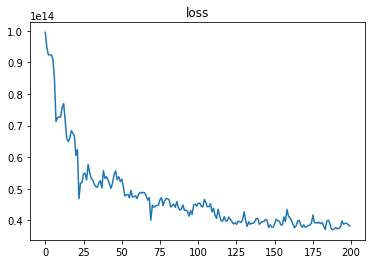

use_train = True Total correct: 1823 accuracy:1823/4000= 0.45575 char_accuracy:4961/7983= 0.6214455718401604
use_train = False Total correct: 490 accuracy:490/1000= 0.49 char_accuracy:1240/1947= 0.6368772470467385
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.0 | Actual Noise: 0.004 | Predicted Text: ba | Actual Text: ca | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.002 | Actual Noise: 0.008 | Predicted Text: ba | Actual Text: ba | Correct: 2
N_predicted: 1 | Actual N: 1 | Predicted Noise: 0.01 | Actual Noise: 0.0 | Predicted Text: c | Actual Text: c | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.005 | Actual Noise: 0.003 | Predicted Text: cc | Actual Text: cc | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.001 | Actual Noise: 0.007 | Predicted Text: baa | Actual Text: bba | Correct: 2
N_predicted: 1 | Actual N: 1 | Predicted Noise: 0.0 | Actual Noise: 0.0 | Predicted Text: c | Actual Text: c | Correct: 1
N_predicted: 2 | Actual N: 2 

In [ ]:
class CaptchaModel(nn.Module):
    """
    network, model and guide wrapper class
    """
    def __init__(self, use_cuda=False):
        super().__init__()
        self.num_char_domain = torch.arange(MIN_N, MAX_N + 1)
        if use_cuda:
            self.num_char_domain = self.num_char_domain.cuda()

        self.numNet = NumNet((captchaHeight, captchaWidth), len(self.num_char_domain))
        self.noiseNet = NoiseNet((captchaHeight, captchaWidth), 1)
        self.char_dict = char_dict # letter dictionary
        self.rnn_hidden_size = 512
        self.rnn_num_layer = 2
        self.charNetSingle = CharNetSingle((captchaHeight, captchaWidth), len(self.char_dict), N_num_class=max(self.num_char_domain), input_size=1024 + max(self.num_char_domain) * 2 + 1, hidden_size=self.rnn_hidden_size, num_layers=self.rnn_num_layer)
        self.noise_constraint = torch.distributions.constraints.interval(MIN_NOISE, MAX_NOISE)
        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
    
    def _map_to_noise_range(self, input):
        """
        map input number to the valid noise range
        """
        input = torch.distributions.transform_to(self.noise_constraint)(input)
        return input

    def guide(self, observations={"captcha": torch.rand(1, captchaHeight, captchaWidth)}):
        pyro.module("guide", self)
        img = observations["captcha"].float()
        
        # posterior to the number of letters
        prob = self.numNet(img)
        prob = torch.mean(prob, dim=0)
        N_index = pyro.sample("num_char", dist.Categorical(prob))
        N_index = torch.add(N_index, self.num_char_domain[0])
        
        with pyro.plate("data", img.shape[0]):
            
            # posterior to the noise
            noise_mean, noise_sig = self.noiseNet(img)
            noise_batch = pyro.sample("noise", dist.Normal(noise_mean, noise_sig).to_event(1))
            noise_batch = self._map_to_noise_range(noise_batch)
            
            # posterior to the characters, given number of letters and noise
            charP = self.charNetSingle(img, N_index, noise_batch)
            pyro.sample("chars", dist.Categorical(charP).to_event(1))
    
    def model(self, observations={"captcha": torch.rand(1, captchaHeight, captchaWidth)}):
        
        BS = observations["captcha"].shape[0]
        
        num_p = torch.tensor(1 / len(self.num_char_domain)).repeat(len(self.num_char_domain))
        
        if self.use_cuda:
            num_p = num_p.cuda()
        
        # sample the number of characters
        N_index = pyro.sample("num_char", dist.Categorical(num_p))
        N_index = torch.add(N_index,  self.num_char_domain[0])
        
        with pyro.plate("data", BS):
            
            noise_mean = torch.tensor((MAX_NOISE - MIN_NOISE) / 2).repeat((BS, 1))
            noise_sig = torch.tensor(0.5).repeat((BS, 1))

            if self.use_cuda:
                noise_mean = noise_mean.cuda()
                noise_sig = noise_sig.cuda()

            # sample the noise
            noise_batch = pyro.sample("noise", dist.Normal(noise_mean, noise_sig).to_event(1))
            noise_batch = self._map_to_noise_range(noise_batch)

            num_c = torch.tensor(1 / len(self.char_dict)).repeat((BS, N_index, len(self.char_dict)))
            if self.use_cuda:
                    num_c = num_c.cuda()
                    
            # sample the character indices
            c = pyro.sample("chars", dist.Categorical(num_c).to_event(1)) # maybe 2 here
            rendered_images = []
            for i in range(c.shape[0]):
                chars = ""
                for j in range(N_index):
                    chars += self.char_dict[c[i][j]]
        
                rendered_image = render_image(chars, noise=float(noise_batch[i]), use_cuda=self.use_cuda)
                rendered_images.append(rendered_image)
                
        rendered_images = torch.stack(rendered_images)
        sigma = torch.tensor(0.000001)
        if self.use_cuda:
                sigma = sigma.cuda()

        pyro.sample("captcha", dist.Normal(rendered_images, sigma).to_event(2), obs=observations["captcha"])

captchaModel = CaptchaModel(USE_CUDA)

optimiser = pyro.optim.Adam({'lr': 5e-5})
svi = SVI(captchaModel.model, captchaModel.guide, optimiser, loss=Trace_ELBO())
#csis = pyro.infer.CSIS(captchaModel.model, captchaModel.guide, optimiser, num_inference_samples=1)


optimize(USE_CUDA)
test_cycle(USE_CUDA)

Optimizing...
loss at epoch 1 is 39577480543083.07
loss at epoch 2 is 40441842474448.63
loss at epoch 3 is 41204806988505.07
loss at epoch 4 is 38826589841714.41
loss at epoch 5 is 39916926975277.34
use_train = True Total correct: 1740 accuracy:1740/4000= 0.435 char_accuracy:5089/7983= 0.6374796442440185
use_train = False Total correct: 422 accuracy:422/1000= 0.422 char_accuracy:1281/1979= 0.6472966144517434
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.002 | Actual Noise: 0.0 | Predicted Text: cc | Actual Text: cc | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.008 | Actual Noise: 0.002 | Predicted Text: cc | Actual Text: bc | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.008 | Actual Noise: 0.001 | Predicted Text: ac | Actual Text: ac | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.003 | Actual Noise: 0.009 | Predicted Text: aa | Actual Text: aa | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.004 | Actual Noise: 0.006 | 

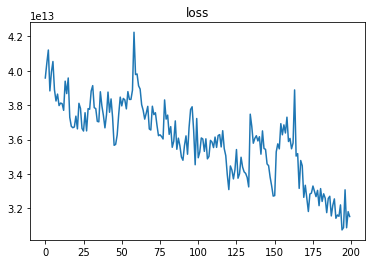

In [ ]:
optimize(USE_CUDA)